# EKF 

In [3]:
import numpy as np
import scipy
import argparse
import sys
import os
import time

def fOde(theta, x):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    logSdt = -theta[0] * np.exp(logI) / N  # (1)
    logEdt = theta[0] * np.exp(logS + logI - logE) / N - theta[1]  # (2)
    logIdt = np.exp(logE - logI) * theta[1] - theta[2]  # (3)
    logDdt = np.exp(logI - logD) * theta[3] * theta[2] * 0.25  # (4)
    return np.stack([logSdt, logEdt, logIdt, logDdt], axis=1)


# Derivatives of X
def fOdeDx(theta, x):
    """
    returns derivation of x given theta
    theta: list[4]
    x: array(n, 4)
    r: array(n, 4, 4)
    """
    resultDx = np.zeros(shape=[np.shape(x)[0], np.shape(x)[1], np.shape(x)[1]])
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    # [:, i, j]: 第j个方程关于第i个状态求导
    # (1) / dI
    resultDx[:, 2, 0] = -theta[0] * np.exp(logI) / N
    # (1) / dS, (1) /dE, (1) / dD = 0
    # (2) / dS
    resultDx[:, 0, 1] = theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dE
    resultDx[:, 1, 1] = -theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dI
    resultDx[:, 2, 1] = theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dD = 0
    # (3) / dS = 0
    # (3) / dE
    resultDx[:, 1, 2] = np.exp(logE - logI) * theta[1]
    # (3) / dI
    resultDx[:, 2, 2] = -np.exp(logE - logI) * theta[1]
    # (3) / dD = 0, (4) / dS, dE = 0
    # (4) / dI
    resultDx[:, 2, 3] = np.exp(logI - logD) * theta[3] * theta[2] * 0.25
    # (4) / dD
    resultDx[:, 3, 3] = -np.exp(logI - logD) * theta[3] * theta[2] * 0.25
    return resultDx


def fOdeDtheta(theta, x):
    """
    returns derivation of theta given x
    theta: list[4]
    x: array(n, 4)
    r: array(n, 4, 4)
    """
    global N
    resultDtheta = np.zeros(shape=[np.shape(x)[0], np.shape(theta)[0], np.shape(x)[1]])
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    # [:, i, j]: 第j个方程对theta_i求导
    # (1) / dRe
    resultDtheta[:, 0, 0] = -np.exp(logI) / N
    # (2) / d theta[0]
    resultDtheta[:, 0, 1] = np.exp(logS + logI - logE) / N
    # (2) / theta[1]
    resultDtheta[:, 1, 1] = -1.
    # (3) / dtheta[1]
    resultDtheta[:, 1, 2] = np.exp(logE - logI)
    # (3) / dtheta[2]
    resultDtheta[:, 2, 2] = -1.
    # (4) / theta[2]
    resultDtheta[:, 2, 3] = np.exp(logI - logD) * theta[3] * 0.25
    # (4) / theta[3]
    resultDtheta[:, 3, 3] = np.exp(logI - logD) * theta[2] * 0.25
    return resultDtheta

def fOdeScipy(t, z, a, b, c, d):
    logS = z[0]
    logE = z[1]
    logI = z[2]
    logD = z[3]
    theta = [a, b, c, d]
    logSdt = -theta[0] * np.exp(logI) / N  # (1)
    logEdt = theta[0] * np.exp(logS + logI - logE) / N - theta[1]  # (2)
    logIdt = np.exp(logE - logI) * theta[1] - theta[2]  # (3)
    logDdt = np.exp(logI - logD) * theta[3] * theta[2] * 0.25  # (4)

    return [logSdt, logEdt, logIdt, logDdt]


discretization = 1
time_ls = np.zeros(100)
N = 100000
days = 32
obs_per_day = 1
ekf_ls = np.zeros((100, days * discretization, 8))

for EachRep in range(100):
    start_time = time.time()
    yobs = np.load('SEIRD observations.npy')[EachRep]
    ydata = yobs.copy()
    ydata[:, 1] = np.interp(np.arange(0, days, 1), np.arange(0, days, 2), yobs[::2, 1])
    tvecObs = np.arange(0, 32, 1)
    tvecFull = np.arange(0, 32, 1)
    yFull = np.ndarray([days * discretization, ydata.shape[1]])
    yFull.fill(np.nan)
    yFull[np.arange(0, days * discretization, discretization).astype(int), :] = ydata
    xInitExogenous = np.zeros_like(yFull)
    for j in range(ydata.shape[1]):
        xInitExogenous[:, j] = np.interp(tvecFull, tvecObs, ydata[:, j])

    noise = 0.2
    dim_x = 4
    dim_theta = 4
    prior_mean_x0_theta = np.array([yFull[0, 0], yFull[0, 1], yFull[0, 2], yFull[0, 3], 1.8, 0.1, 0.1, 0.2])
    prior_variance_x0_theta = np.diag([noise ** 2, noise ** 2,noise ** 2,noise ** 2, 1, 1, 1, 1])
    theta_roaming_variance_unit_time = np.diag([0.05, 0.05, 0.01, 0.01])

    estimate_x_theta = np.zeros(shape=[yFull.shape[0], dim_x + dim_theta])
    variance_x_theta = np.zeros(shape=[yFull.shape[0], dim_x + dim_theta, dim_x + dim_theta])

    estimate_x_theta[0] = prior_mean_x0_theta
    variance_x_theta[0] = prior_variance_x0_theta

    for k in range(1, yFull.shape[0]):
        delta_t = tvecFull[k] - tvecFull[k-1]
        predicted_theta = estimate_x_theta[k - 1, dim_x:(dim_x + dim_theta)]
        previous_x = estimate_x_theta[k - 1, 0:dim_x]
        predicted_x = previous_x + delta_t * fOde(predicted_theta, previous_x.reshape([1, -1])).reshape([-1])
        jacobian_predict_x_x = delta_t * fOdeDx(predicted_theta, previous_x.reshape([1, -1])).reshape([dim_x, dim_x])
        jacobian_predict_x_x += np.eye(dim_x)
        jacobian_predict_x_theta = delta_t * fOdeDtheta(predicted_theta, previous_x.reshape([1, -1])).reshape([dim_theta, dim_x])
        jacobian_predict_theta_x = np.zeros([dim_x, dim_theta])
        jacobian_predict_theta_theta = np.eye(dim_theta)
        jacobian_predict = np.block([
            [jacobian_predict_x_x, jacobian_predict_theta_x],
            [jacobian_predict_x_theta, jacobian_predict_theta_theta]
        ])
        variance_predict = jacobian_predict.transpose() @ variance_x_theta[k-1] @ jacobian_predict
        variance_predict[dim_x:(dim_x + dim_theta), dim_x:(dim_x + dim_theta)] += theta_roaming_variance_unit_time * delta_t
        predicted_x_theta = np.concatenate([predicted_x, predicted_theta])
        if not np.any(np.isfinite(yFull[k, :])):
            variance_x_theta[k] = variance_predict
            estimate_x_theta[k] = predicted_x_theta
        else:
            yobs = yFull[k, :]
            jacobian_y_x =  np.eye(dim_x)
            jacobian_y_theta =  np.zeros([dim_theta, dim_x])
            jacobian_y = np.block([
                [jacobian_y_x],
                [jacobian_y_theta]
            ])
            idx_yobs = np.isfinite(yobs)
            yobs = yobs[idx_yobs]
            jacobian_y = jacobian_y[:, idx_yobs]
            predicted_y = predicted_x[idx_yobs]
            variance_predicted_yobs = jacobian_y.transpose() @ variance_predict @ jacobian_y + noise**2 * np.eye(yobs.shape[0])
            covariance_xtheta_yobs = variance_predict @ jacobian_y
            invvar_predicted_yobs = np.linalg.inv(variance_predicted_yobs)
            predicted_x_theta = predicted_x_theta + covariance_xtheta_yobs @ invvar_predicted_yobs @ (yobs - predicted_y)
            condvar_x_theta = variance_predict - covariance_xtheta_yobs @ invvar_predicted_yobs @ covariance_xtheta_yobs.transpose()

            variance_x_theta[k] = condvar_x_theta
            estimate_x_theta[k] = predicted_x_theta

    ekf_ls[EachRep] = estimate_x_theta
    time_ls[EachRep] = time.time() - start_time
print(np.mean(time_ls), np.std(time_ls))

0.007984986305236816 0.0004149916642672497


In [4]:
all_beta = ekf_ls[:, :, 4]
all_ve = ekf_ls[:, :, 5]
all_vi = ekf_ls[:, :, 6]
all_pd = ekf_ls[:, :, 7]


nobs = days * obs_per_day
N = 100000.
X = np.arange(0, days, 1. / (obs_per_day * discretization))
i0 = 50
e0 = 100
T = 2
parameter_value = [1.8, 0.1, 0.1, 0.05]
std = [1., 0.02, 0, 0.025]


tmp_2 = np.linspace(0, 2 * T * np.pi, discretization * nobs)
true_beta = parameter_value[0] - std[0] * np.cos(tmp_2)
true_ve = parameter_value[1]- std[1] * np.cos(tmp_2)
true_vi = parameter_value[2]
true_pd = parameter_value[3] + std[3] * np.cos(tmp_2)

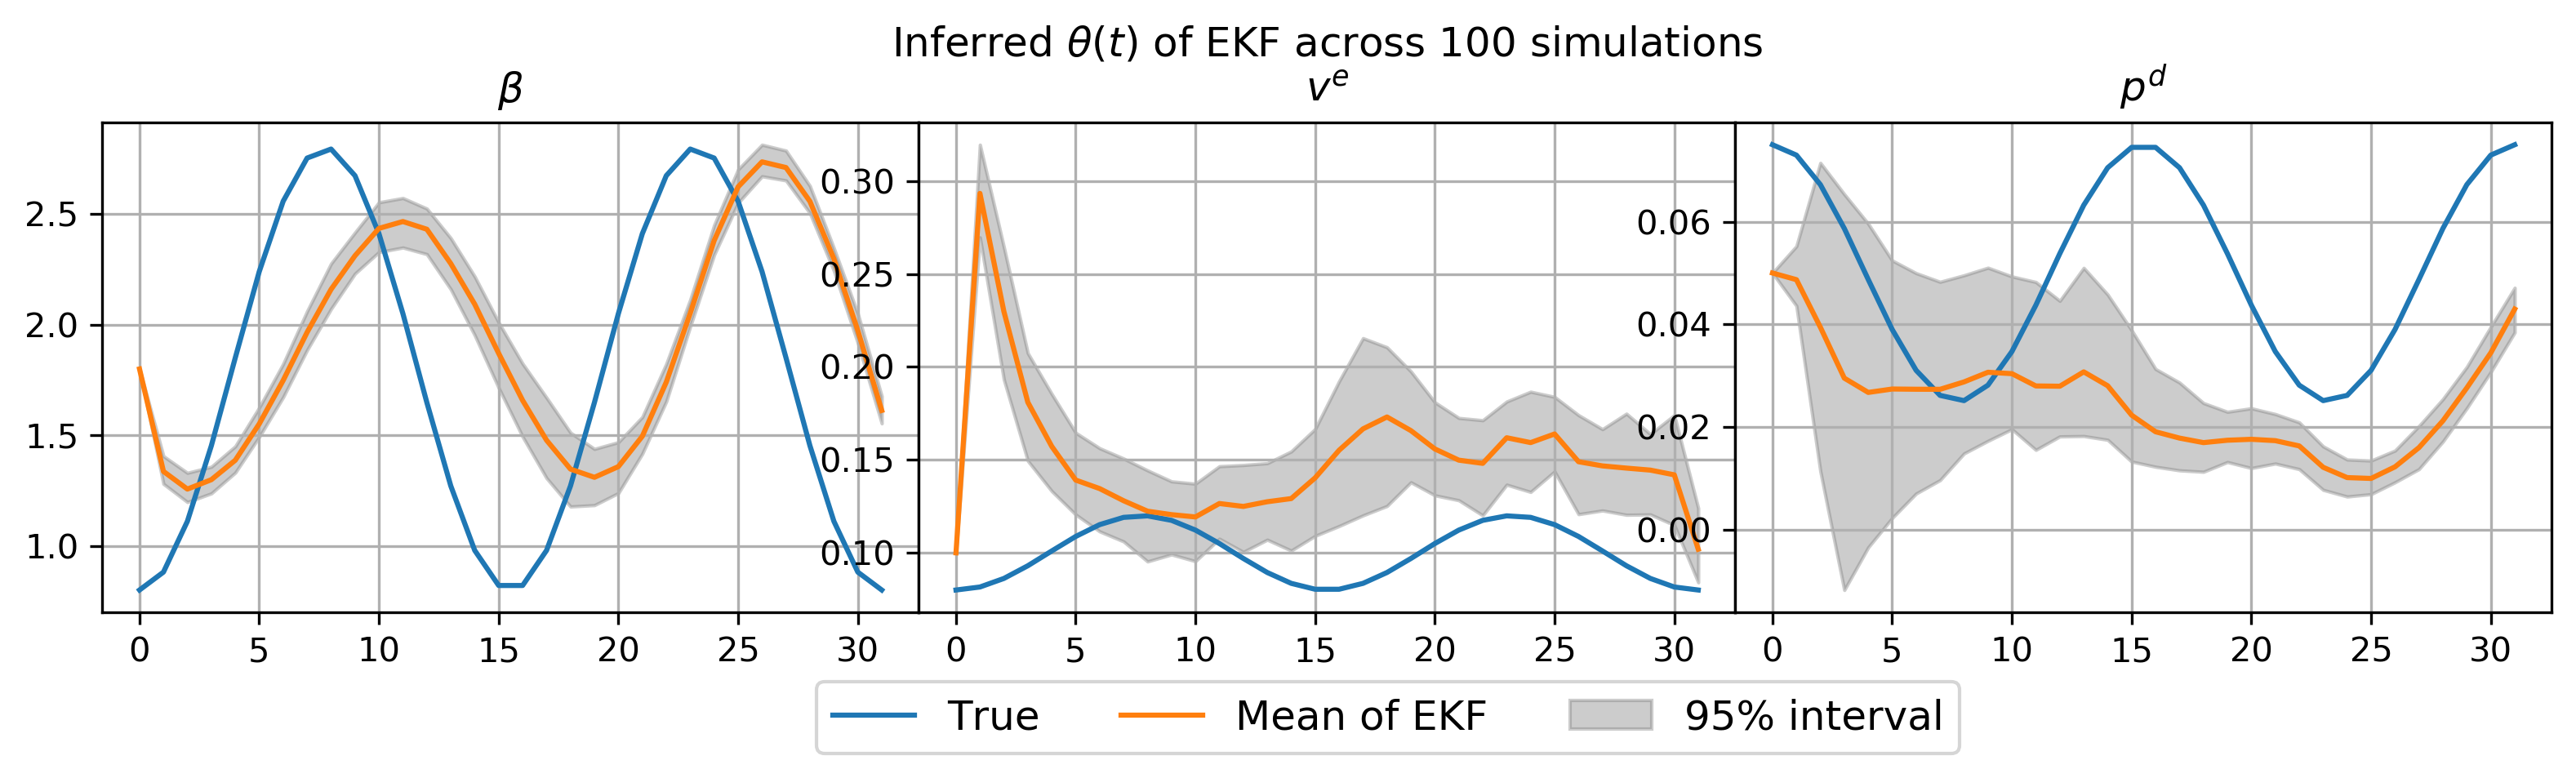

In [6]:
%matplotlib inline
import matplotlib # 注意这个也要import一次
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize # import figsize
#figsize(12.5, 4) # 设置 figsize
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率

figsize(10, 2)
plt.subplots_adjust(top=1,bottom=0,left=0,right=1, wspace = 0, hspace = 0)
x = np.arange(0, 32, 1 / discretization)

ax1 = plt.subplot(1, 3, 1) # 两行一列，位置是1的子图
lower_95 = np.percentile(all_beta, 97.5, axis=0)
upper_95 = np.percentile(all_beta, 2.5, axis=0)

plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4, label='95% interval')
plt.plot(x, true_beta, label='True')
plt.plot(x, np.mean(all_beta, axis=0), label='Mean of EKF')

plt.title(r'$\beta$')
plt.grid()
plt.legend(bbox_to_anchor=(2.3, -0.1), fontsize=12, ncol=4)

ax2 = plt.subplot(1, 3, 2)
lower_95 = np.percentile(all_ve, 97.5, axis=0)
upper_95 = np.percentile(all_ve, 2.5, axis=0)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(x, true_ve)
plt.plot(x, np.mean(all_ve, axis=0))

plt.grid()
plt.title(r'$v^e$')


ax3 = plt.subplot(1, 3, 3)
lower_95 = np.percentile(all_pd, 97.5, axis=0)
upper_95 = np.percentile(all_pd, 2.5, axis=0)
plt.fill_between(x, lower_95 / 4, upper_95 / 4, color='grey', alpha = 0.4)
plt.plot(x, true_pd)
plt.plot(x, np.mean(all_pd / 4, axis=0))
plt.title(r'$p^d$')
plt.suptitle(r'Inferred $\theta(t)$ of EKF across 100 simulations', y=1.2)
plt.grid()

In [7]:
def recover_data(true_re, true_ve, true_vi, true_pd, days, obs_per_day, state0=[N, 100, 50, 50], linspace=1000):
    """
    params: parameter: [beta, ve, vi, pd]
    """
    # check input
    # [ S, E, I, D, cfr0]
    freq = 1. / discretization
    nFull = days * obs_per_day
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((nFull * linspace, 4))
    state_ls[0][0] = state0[0]
    state_ls[0][1] = state0[1]
    state_ls[0][2] = state0[2]
    state_ls[0][3] = state0[3]

    for i in range(1, linspace * nFull):
        index = int(i / linspace)
        state_ls[i][0] = state_ls[i - 1][0] - step_size * true_re[index] * state_ls[i - 1][2] * state_ls[i - 1][0] / N
        state_ls[i][1] = state_ls[i - 1][1] + step_size * true_re[index] * state_ls[i - 1][2] * state_ls[i - 1][0] / N - step_size * max(true_ve[index], 0) * state_ls[i - 1][1]
        state_ls[i][2] = state_ls[i - 1][2] + step_size * max(true_ve[index], 0) * state_ls[i - 1][1] - step_size * state_ls[i - 1][2] * max(true_vi[index], 0)
        state_ls[i][3] = state_ls[i - 1][3] + step_size * state_ls[i - 1][2] * max(true_vi[index], 0) * true_pd[index] / 4
    states = state_ls[::linspace]
    # add noise
    return states



fitted = np.zeros((100, days * discretization, 4))
for i in range(100):
#     print(i)
    fitted[i] = recover_data(all_beta[i], all_ve[i], all_vi[i], all_pd[i], days=32, obs_per_day=1, state0 = [100000, 100, 50, 50])

In [8]:
def true_data(days=32, obs_per_day=1, state0=[100000., 100., 50., 50.], linspace=1000):
    """
    params: parameter: [beta, ve, vi, pd]
    """
    # check input
    parameter_value = [1.8, 0.1, 0.1, 0.05]
    std = [1., 0.02, 0, 0.025]
    tmp = np.linspace(0, 2 * T * np.pi, 32000)
    true_re = parameter_value[0] - std[0] * np.cos(tmp)
    true_ve = parameter_value[1]- std[1] * np.cos(tmp)
    true_vi = parameter_value[2] 
    true_pd = parameter_value[3] + std[3] * np.cos(tmp)
    nFull = int(days * obs_per_day)
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((nFull * linspace, 4))
    state_ls[0][0] = state0[0]
    state_ls[0][1] = state0[1]
    state_ls[0][2] = state0[2]
    state_ls[0][3] = state0[3]

    for i in range(1, linspace * nFull):
        index = i - 1
        state_ls[i][0] = state_ls[i - 1][0] - step_size * true_re[index] * state_ls[i - 1][2] * state_ls[i - 1][0] / N
        state_ls[i][1] = state_ls[i - 1][1] + step_size * true_re[index] * state_ls[i - 1][2] * state_ls[i - 1][0] / N - step_size * true_ve[index] * state_ls[i - 1][1]
        state_ls[i][2] = state_ls[i - 1][2] + step_size * true_ve[index] * state_ls[i - 1][1] - step_size * state_ls[i - 1][2] * true_vi
        state_ls[i][3] = state_ls[i - 1][3] + step_size * state_ls[i - 1][2] * true_vi  * true_pd[index]
    states = state_ls[::linspace]
    return states

true_x = true_data()

Text(0.5, 1.2, 'Reconstructed $x(t)$ of EKF across 100 simulations')

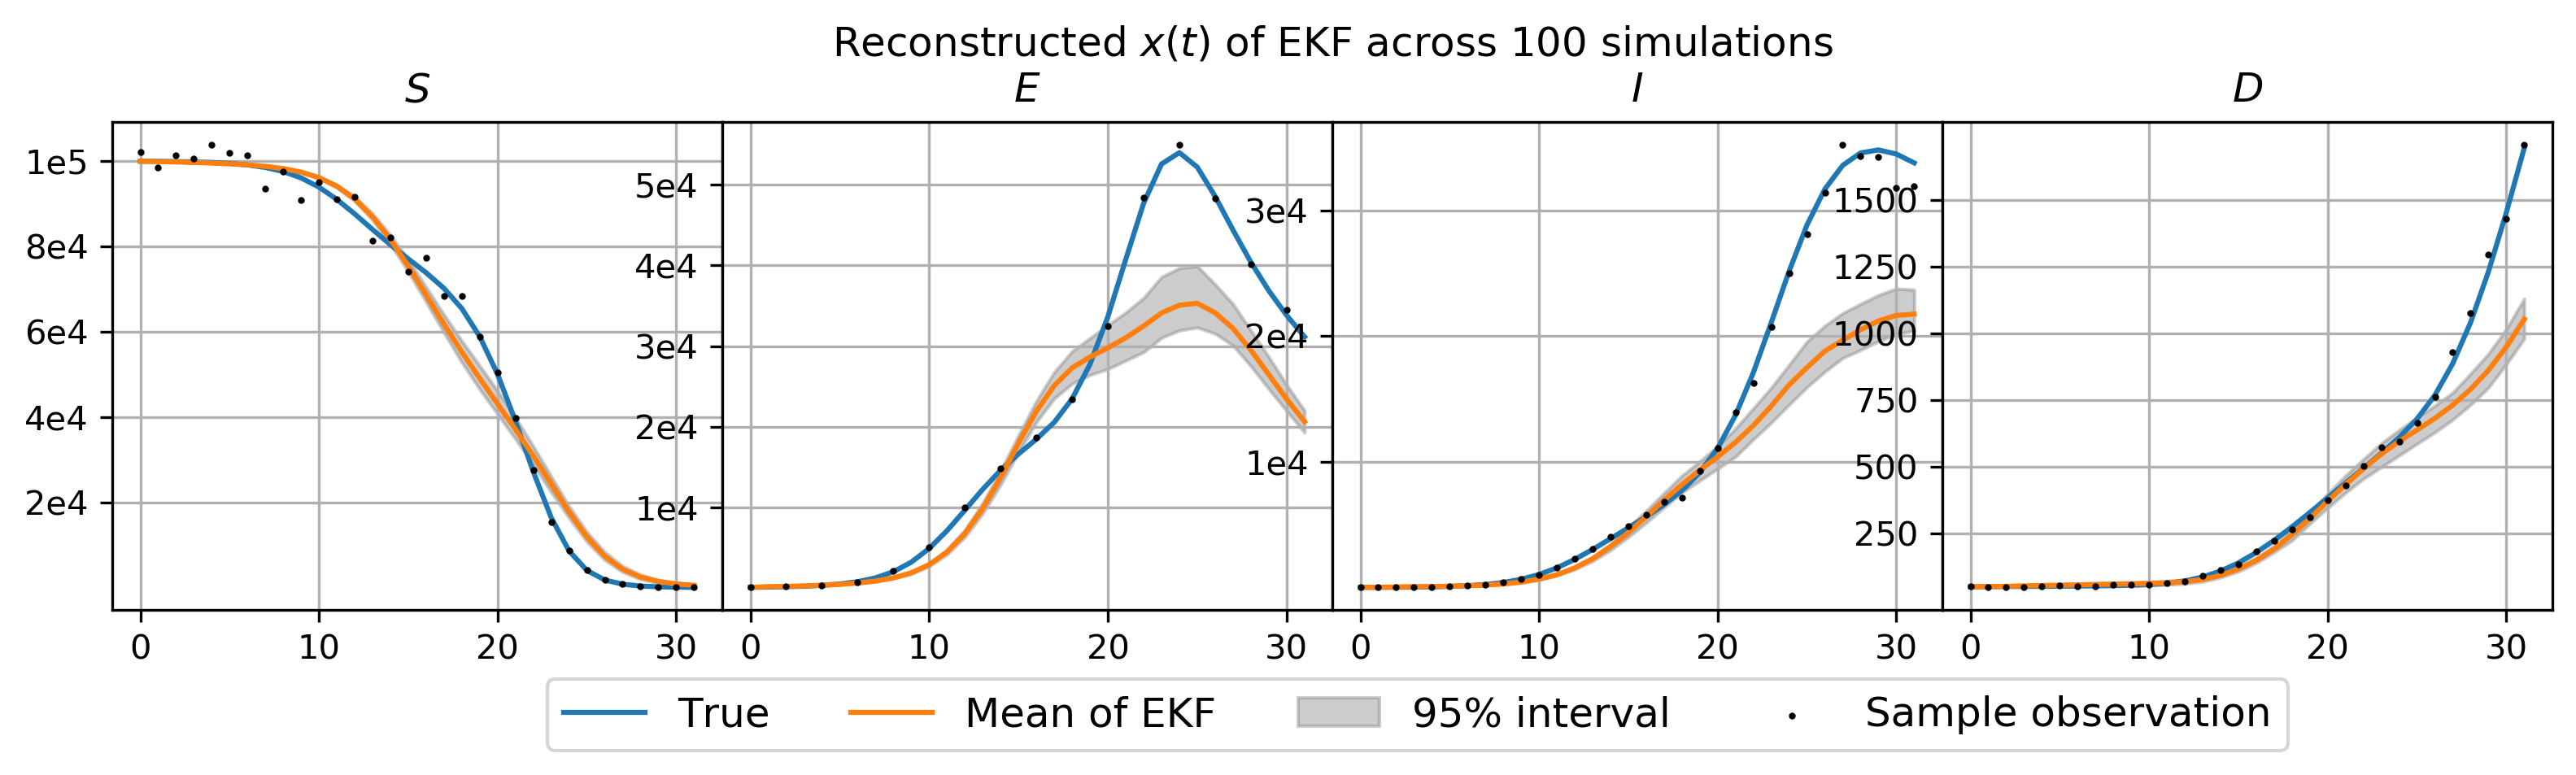

In [10]:
yobs = np.exp(np.load('SEIRD observations.npy')[1])
figsize(10, 2)
plt.subplots_adjust(top=1,bottom=0,left=0,right=1, wspace =0, hspace =0)
ax1 = plt.subplot(1, 4, 1) # 两行一列，位置是1的子图
lower_95 = np.percentile(fitted[:,:, 0], 97.5, axis=0)
upper_95 = np.percentile(fitted[:,:, 0], 2.5, axis=0)
x = np.arange(0, 32, 1 / discretization)
plt.yticks(np.array([20000, 40000, 60000, 80000, 100000]), ['2e4', '4e4', '6e4', '8e4', '1e5'])
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4, label='95% interval')
plt.plot(true_x[:, 0], label='True')
plt.plot(x, np.mean(fitted[:,:, 0], axis=0), label='Mean of EKF')
plt.scatter(np.arange(0, 32, 1), yobs[:, 0], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title(r'$S$')
plt.legend(bbox_to_anchor=(3.6, -0.1), fontsize=12, ncol=4)

ax2 = plt.subplot(1, 4, 2)
lower_95 = np.percentile(fitted[:,:, 1], 97.5, axis=0)
upper_95 = np.percentile(fitted[:,:, 1], 2.5, axis=0)
plt.yticks(np.array([10000, 20000, 30000, 40000, 50000]), ['1e4', '2e4', '3e4', '4e4', '5e4'])
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(true_x[:, 1])
plt.plot(x, np.mean(fitted[:,:, 1], axis=0))
plt.scatter(np.arange(0, 32, 1), yobs[:, 1], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title(r'$E$')


ax3 = plt.subplot(1, 4, 3)
lower_95 = np.percentile(fitted[:,:, 2], 97.5, axis=0)
upper_95 = np.percentile(fitted[:,:, 2], 2.5, axis=0)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.yticks(np.array([10000, 20000, 30000]), ['1e4', '2e4', '3e4'])
plt.plot(true_x[:, 2])
plt.plot(x, np.mean(fitted[:,:, 2], axis=0))
plt.scatter(np.arange(0, 32, 1), yobs[:, 2], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title(r'$I$')


ax4= plt.subplot(1, 4, 4)
lower_95 = np.percentile(fitted[:,:, 3], 97.5, axis=0)
upper_95 = np.percentile(fitted[:,:, 3], 2.5, axis=0)
plt.yticks(np.array([250,500,750,1000,1250,1500]))
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(true_x[:, 3])
plt.plot(x, np.mean(fitted[:,:, 3], axis=0))
plt.scatter(np.arange(0, 32, 1), yobs[:, 3], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title(r'$D$')
plt.suptitle(r'Reconstructed $x(t)$ of EKF across 100 simulations', y=1.2)

# RMSE 

In [18]:
RMSE_S = np.zeros(100)
RMSE_E = np.zeros(100)
RMSE_I = np.zeros(100)
RMSE_D = np.zeros(100)

for i in range(100):
    RMSE_S[i] = np.sqrt(np.mean(np.square(fitted[i, ::discretization, 0] - true_x[:, 0])))
    RMSE_E[i] = np.sqrt(np.mean(np.square(fitted[i, ::discretization, 1] - true_x[:, 1])))
    RMSE_I[i] = np.sqrt(np.mean(np.square(fitted[i, ::discretization, 2] - true_x[:, 2])))
    RMSE_D[i] = np.sqrt(np.mean(np.square(fitted[i, ::discretization, 3] - true_x[:, 3])))
print(np.mean(RMSE_S), np.std(RMSE_S))
print(np.mean(RMSE_E), np.std(RMSE_E))
print(np.mean(RMSE_I), np.std(RMSE_I))
print(np.mean(RMSE_D), np.std(RMSE_D))

4598.953031522364 279.85832074257246
8319.781768530704 790.8559991469615
6447.7646959210215 453.4490962368532
168.32052417710958 13.356207109481783


In [19]:
RMSE_beta = np.zeros(100)
RMSE_ve = np.zeros(100)
RMSE_vi = np.zeros(100)
RMSE_pd = np.zeros(100)

for i in range(100):
    RMSE_beta[i] = np.sqrt(np.mean(np.square(all_beta[i] - true_beta)))
    RMSE_ve[i] = np.sqrt(np.mean(np.square(all_ve[i] - true_ve)))
    RMSE_vi[i] = np.sqrt(np.mean(np.square(all_vi[i] - true_vi)))
    RMSE_pd[i] = np.sqrt(np.mean(np.square(all_pd[i]/4 - true_pd)))
    
print(np.mean(RMSE_beta), np.std(RMSE_beta))
print(np.mean(RMSE_ve), np.std(RMSE_ve))
print(np.mean(RMSE_vi), np.std(RMSE_vi))
print(np.mean(RMSE_pd), np.std(RMSE_pd))

0.7375634696891358 0.015239754875935447
0.06634291147303334 0.005189253977642793
0.18423270365930486 0.020738868234823033
0.030855696278673385 0.002286968320125507


In [3]:
from platform import python_version

print(python_version())

3.7.3
